### Load base model (names set as *_nonlinear.pth)

In [14]:
from ptlpinns.models import model, training, load, transfer
from ptlpinns.odes import forcing, numerical, equations
import numpy as np
import torch
import time
import matplotlib.pyplot as plt

name = "undamped_nonlinear"
base_path = f"/home/dda24/PTL-PINNs/ptlpinns/models/train/{name}/"
base_name = f"model_{name}.pth"
base_model, training_log = model.load_model(base_path, base_name)

7 True True True 1.0 16 [256, 256, 512]


### Initialize transfer learning model

In [15]:
transfer_model = model.transfer_model(training_log, base_model)

### Transfer learning parameters

In [16]:
w_transfer = [1]
zeta_transfer = [0]
q = 3
N = 512
t_span = (0, 10)
t_eval = np.linspace(t_span[0], t_span[1], N)
ic = [1, 0]
initial_condition_functions = [load.initial_condition(y1_0=ic[0], y2_0=ic[1])]
epsilon = 0.5
equation_functions = [equations.equation_oscillator(w_0=w_transfer[0], epsilon=epsilon, zeta=zeta_transfer[0])]
forcing_functions = [forcing.zeroes_2D(False)]

In [17]:
ode = equations.ode_oscillator_1D(w_0=w_transfer[0], zeta=zeta_transfer[0], forcing_1D = lambda t: np.zeros_like(t), q=q, epsilon=epsilon)
numerical_solution = numerical.solve_ode_equation(ode, (t_eval[0], t_eval[-1]), t_eval, ic)

### Transfer learning

In [18]:
optimizer = torch.optim.Adam(model.head_parameters(transfer_model), lr=1e-2)
num_iter = 50000
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.95)

In [19]:
transfer.compute_transfer_learning(transfer_model, optimizer, num_iter,
                        equation_functions, initial_condition_functions, forcing_functions,
                        N=N, t_span=t_span, numerical_solution=numerical_solution, every=500,
                        ode_weight=2, ic_weight=1.0)

Converged at iteration 486: MAE = 0.014970837508972046 | time 31.201513547992363


### Plotting the results

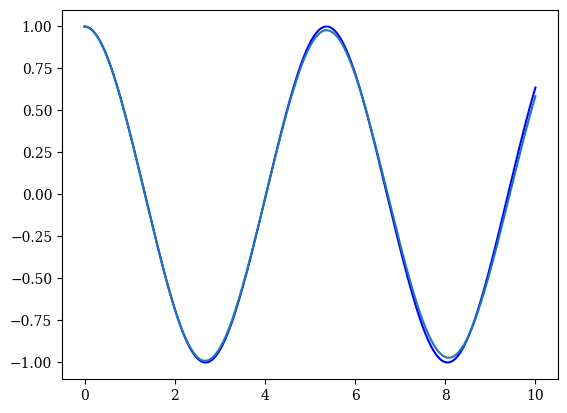

In [20]:
plt.plot(t_eval, numerical_solution[0, :], label='Numerical Solution', color='blue')
plt.plot(t_eval, transfer_model(training.generate_eval_tensor(N, t_span, False))[0].squeeze()[:, 0].detach().numpy())